# 比赛第八名解决方案

[百度网盘大赛二，手写文字擦除](https://aistudio.baidu.com/aistudio/competition/detail/129/0)

感谢百度组织比赛，感谢团队成员共同努力

特别感谢Jordan2020开源的 [基于MTRNet++ 实现图像文字擦除,榜评分0.55599](https://aistudio.baidu.com/aistudio/projectdetail/3439995?contributionType=1)方案，受益颇多。




# 一、算法介绍
俗话说，选择一个好的baseline就成功了一半（手动狗头），拿到数据集后，我们用Pixel2Pixel，CycleGAN，EnsNet，MTRNet++进行了测试，最后选定了MTRNet++作为baseline。
理由是：~~带加号的一般更强，这个模型带了俩加号~~

1. End2End，集成度好；
2. 模型小，效果也不差，有魔改空间；
3. 网络设计更贴近本次比赛任务。

网络架构图：

从MTRNet++
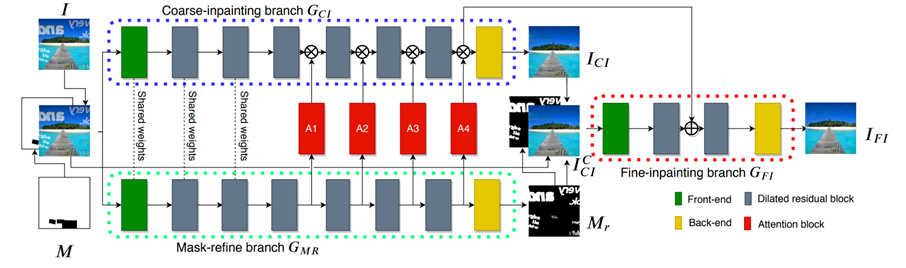
改成了
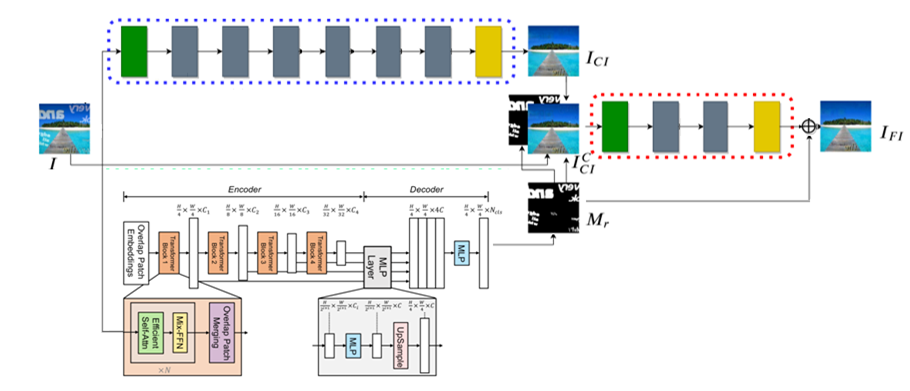
请大家酌情dis

魔改思路：

1. 移除输入mask。MTRNet++需要输入mask作为第四通道，~~这多不方便，我们给扔了吧~~若采用全图1填充的方法，感觉这数据多余了，但如果想传入高精度的分割结果，如何获取准确的Mask本身就是一个挑战。因此，我们删除了第四通道，用基于transformer的segformer替代网络中生成msdk的部分，删除A1-A4的门结构，使网络松耦合，便于分离、调优（详见第三节实践调优部分）。

2. 修复区域聚焦。原文中，预生成图片（中间那张图，经过GCI后的生成图）经过了cmp（mask白色区域选择生成图片内容，黑色区域选择原图内容，进行叠加生成一张新的图片）操作，我们把这个机制引入到了下一个迭代，最后生成的图片也经过cmp操作后，再与GT做loss运算，这样生成网络的梯度几乎全部来源于mask部分，而非mask部分基本被忽略。我们认为这样训练更快，效果更好。






# 二、数据增强

兵马未动，粮草先行。这玩意，就是口粮。

* 数据清洗

测量专业的我们拿到图，第一反应永远是：误差在哪？

经过试验后我们认为：两张图片的差别，由系统差别、人为差别、手写字造成的差别共同造成。
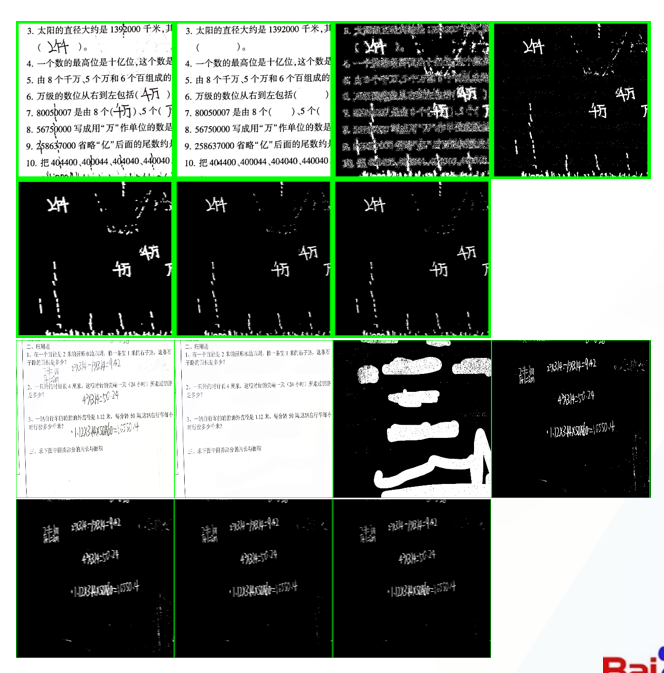

上图中，图片排列顺序如下：
 
原图      真值  阈值1   阈值5

阈值10 阈值15    阈值25

分析结论：

1. 阈值为1出现大量像素点，这部分是由于数据存储压缩、插值等原因造成的，认定为系统差别（非计算机专业，表述可能有问题，请意会，请轻拍）
2. 阈值为5-25基本可见手写字，但出现的噪点不同，因为处理过程中有的作业员把噪点区域擦出了，有的作业员没有擦除（特别是字里行间，不容易处理的地方）
3. 手写字造成的差别，这才是我们真正应该关注的地方

经过数据处理，保留了2、3两类差别，第一类用cmp的方式去除掉了。


增强扩充

1. 结合本数据集与公开数据集形成手写字文字素材

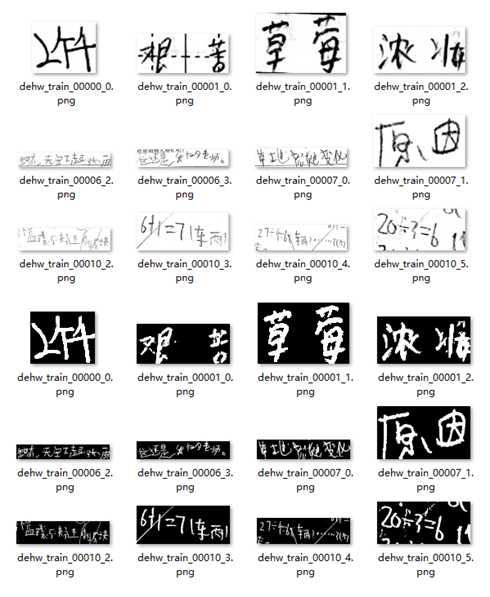

2. 针对括号、圆圈等误识别区形成素材

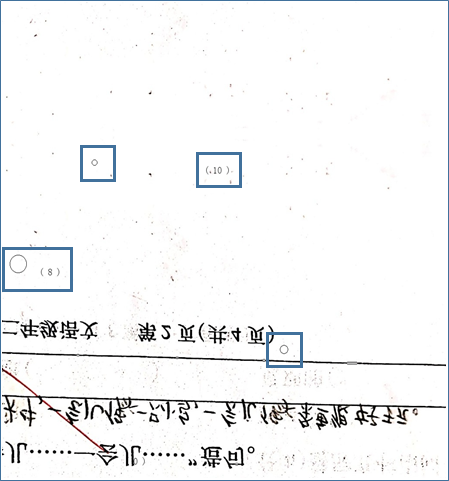

3. MixUp

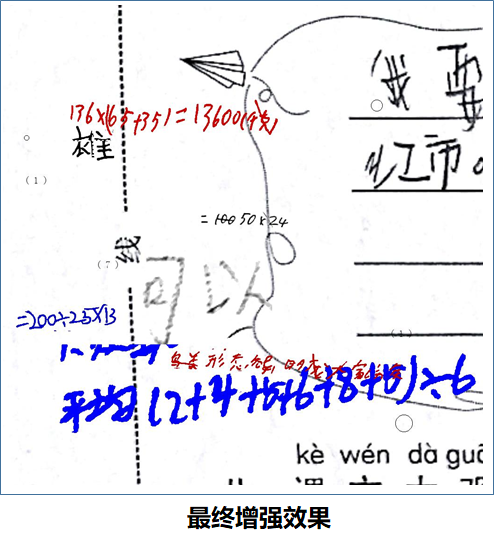


简单粗暴，且卓有成效

# 三、实践调优

代码实现与实践调优：

经过对上述工作后，开始网络训练，发现两个问题：
1. 多任务训练过程中，mask任务生成效果不够理想；
2. 预测过程中，若对mask进行增强预测，有利于提高精度，但一个网络中难以实现。

理论归理论，实践归实践，精度才是最重要的。模型肢解，优雅不在（这也是前面强调松耦合的原因）。

我们把网络分为两块
1. 第一块直接使用PaddleSeg生成网络，单独训练segformerB2
2. 另一块训练本网络的其他部分，包含对抗网络生成器与判别器

推理时使用512 512大小的窗口，256 256步长进行滑动预测，生成整张大图的mask（有重复区域滑动效果好）；随后擦除图片中对应区域的内容，以512X512大小输入后续网络进行预测。



# 四、代码介绍-训练复现介绍


In [1]:
#1.准备原料：解压比赛的数据集
!unzip data/data126557/dehw_testB_dataset.zip -d data/ >>/dev/null
!unzip data/data126586/dataset1.zip -d data/ >>/dev/null
!unzip data/data126586/dataset2.zip -d data/ >>/dev/null

In [4]:
#2.准备工具
!pip install scikit_image
!pip install paddleseg


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 13.3 MB 478 kB/s             
     |████████████████████████████████| 178 kB 18.2 MB/s            
     |████████████████████████████████| 6.1 MB 4.8 MB/s            
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 275 kB 7.5 MB/s            


In [7]:
#3.开始训练第一部分
!python work/train/train_seg.py

2022-01-24 21:52:28 [INFO]	
------------Environment Information-------------
platform: Linux-4.13.0-36-generic-x86_64-with-debian-stretch-sid
Python: 3.7.4 (default, Aug 13 2019, 20:35:49) [GCC 7.3.0]
Paddle compiled with cuda: True
NVCC: Cuda compilation tools, release 10.1, V10.1.243
cudnn: 7.6
GPUs used: 1
CUDA_VISIBLE_DEVICES: None
GPU: ['GPU 0: Tesla V100-SXM2-16GB']
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~16.04) 7.5.0
PaddleSeg: 2.4.0
PaddlePaddle: 2.2.2
OpenCV: 4.1.1
------------------------------------------------
2022-01-24 21:52:28 [INFO]	
---------------Config Information---------------
batch_size: 4
iters: 300000
loss:
  coef:
  - 1
  types:
  - ignore_index: 255
    type: DiceLoss
lr_scheduler:
  learning_rate: 0.01
  power: 1
  type: PolynomialDecay
model:
  num_classes: 2
  pretrained: https://bj.bcebos.com/paddleseg/dygraph/mix_vision_transformer_b2.tar.gz
  type: SegFormer_B2
optimizer:
  momentum: 0.9
  type: sgd
  weight_decay: 4.0e-05
test_config:
  crop_size:
  - 512
  - 5

In [10]:
#4.开始训练第二部分
!python work/train/train.py


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized
W0124 22:00:48.518880  2838 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.0, Runtime API Version: 10.1
W01

# 五、代码介绍-预测代码介绍
本部分包含了预测结果代码，运行方式：
1、B榜图片数据放入/dehw_testB_dataset文件夹下（保留，可直接运行）；
2、运行1_predict_segformer.py文件，在segoutput文件夹中会出现手写字语义分割的结果，效率：5s/step；
3、第二步运行完毕后，运行2_predictgan.py文件
4、最终提交结果出现在submit文件夹中


In [15]:
#1.解压B榜数据集
!unzip data/data126557/dehw_testB_dataset.zip -d data/ >>/dev/null

replace data/dehw_testB_dataset/dehw_testB_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
#2.预测大图mask
!python work/pre_and_submit/1_predict_segformer.py

2022-01-24 19:06:23 [INFO]	
---------------Config Information---------------
batch_size: 4
iters: 300000
loss:
  coef:
  - 1
  types:
  - type: DiceLoss
lr_scheduler:
  learning_rate: 0.01
  power: 1
  type: PolynomialDecay
model:
  num_classes: 2
  pretrained: https://bj.bcebos.com/paddleseg/dygraph/mix_vision_transformer_b2.tar.gz
  type: SegFormer_B2
optimizer:
  momentum: 0.9
  type: sgd
  weight_decay: 4.0e-05
test_config:
  crop_size:
  - 512
  - 512
  is_slide: true
  stride:
  - 384
  - 384
train_dataset:
  dataset_root: work/pre_and_submit/dataset
  mode: train
  num_classes: 2
  train_path: work/pre_and_submit/dataset/train_list (2).txt
  transforms:
  - max_scale_factor: 1.2
    min_scale_factor: 0.8
    scale_step_size: 0.2
    type: ResizeStepScaling
  - crop_size:
    - 512
    - 512
    type: RandomPaddingCrop
  - type: RandomBlur
  - type: RandomHorizontalFlip
  - type: RandomVerticalFlip
  - brightness_range: 0.4
    contrast_range: 0.4
    saturation_range: 0.4
    ty

segoutput路径下生成语义分割结果。如下图所示：
![](https://ai-studio-static-online.cdn.bcebos.com/cc7046eca52f4f8a92111fb86db5d28f619102f71d8341a4aa2ee3d20b5a0545)


In [ ]:
#3.手写字压盖信息修补
!python work/pre_and_submit/2_predictgan.py

submit文件夹下得到预测结果
![](https://ai-studio-static-online.cdn.bcebos.com/344f75524b914312b86f45c7ea44c12f047ca9c55e9e49b581cbe7d8def35619)


In [2]:
#4.压缩文件提交评分
%cd submit/
!zip result.zip *.png *.txt

/home/aistudio/submit
  adding: dehw_testB_100.png (deflated 7%)
  adding: dehw_testB_101.png (deflated 8%)
  adding: dehw_testB_102.png (deflated 8%)
  adding: dehw_testB_103.png (deflated 7%)
  adding: dehw_testB_104.png (deflated 8%)
  adding: dehw_testB_105.png (deflated 12%)
  adding: dehw_testB_106.png (deflated 10%)
  adding: dehw_testB_107.png (deflated 6%)
  adding: dehw_testB_108.png (deflated 7%)
  adding: dehw_testB_109.png (deflated 11%)
  adding: dehw_testB_10.png (deflated 8%)
  adding: dehw_testB_110.png (deflated 12%)
  adding: dehw_testB_111.png (deflated 11%)
  adding: dehw_testB_112.png (deflated 10%)
  adding: dehw_testB_113.png (deflated 11%)
  adding: dehw_testB_114.png (deflated 8%)
  adding: dehw_testB_115.png (deflated 9%)
  adding: dehw_testB_116.png (deflated 9%)
  adding: dehw_testB_117.png (deflated 11%)
  adding: dehw_testB_118.png (deflated 6%)
  adding: dehw_testB_119.png (deflated 8%)
  adding: dehw_testB_11.png (deflated 9%)
  adding: dehw_testB_120.p

# 六、致谢

再次郑重感谢：

感谢百度组织比赛，提供机会与舞台

感谢团队成员共同努力，感谢杨立博同学忍受23：00开讨论会的恶习，感谢沈忱的24小时5分钟重启服务，感谢翟雪奎同学分担火力，感谢吕金声的数据支持、协同保障。

特别感谢：

Jordan2020开源的 [基于MTRNet++ 实现图像文字擦除,榜评分0.55599](https://aistudio.baidu.com/aistudio/projectdetail/3439995?contributionType=1)方案，受益颇多。



